# Assignment - 3

### CS22B1093 Rohan G

----------

### Importing necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

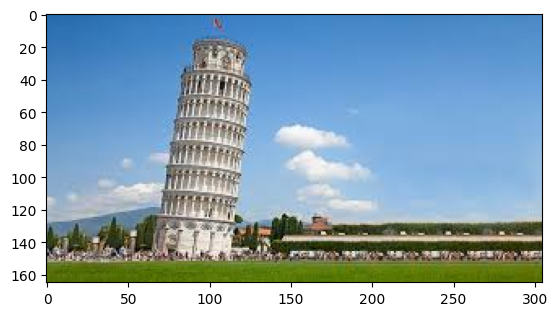

In [3]:
img = cv2.imread("pisa.jpeg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
def rotate_image_predefined(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)
    return rotated_image

In [5]:
def rotate_image_custom_bilinear(image, angle):
    (h, w) = image.shape[:2]
    center_x, center_y = w / 2, h / 2

    rad = np.radians(angle)
    cosA, sinA = np.cos(rad), np.sin(rad)

    rotated = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            x = j - center_x
            y = i - center_y

            src_x = cosA * x - sinA * y + center_x
            src_y = sinA * x + cosA * y + center_y

            if 0 <= src_x < w - 1 and 0 <= src_y < h - 1:
                x0, y0 = int(np.floor(src_x)), int(np.floor(src_y))
                x1, y1 = x0 + 1, y0 + 1

                a = src_x - x0
                b = src_y - y0

                for c in range(image.shape[2]):
                    value = (1 - a) * (1 - b) * image[y0, x0, c] + \
                            a * (1 - b) * image[y0, x1, c] + \
                            (1 - a) * b * image[y1, x0, c] + \
                            a * b * image[y1, x1, c]
                    rotated[i, j, c] = np.clip(value, 0, 255)
            else:
                rotated[i, j] = 0

    return rotated.astype(np.uint8)

In [6]:
def detect_inclination(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=100, maxLineGap=10)
    line_image = image.copy()
    vertical_lines = []

    if lines is None:
        print("No lines were detected.")
        return line_image, None

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
        
        angle_line = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if angle_line < 0:
            angle_line += 180

        if 70 < angle_line < 110:
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            vertical_lines.append((angle_line, length))

    if vertical_lines:
        weighted_sum = sum(angle * length for angle, length in vertical_lines)
        total_length = sum(length for _, length in vertical_lines)
        avg_angle = weighted_sum / total_length if total_length != 0 else 90
        inclination = abs(avg_angle - 90)

        print(f"Weighted average line angle: {avg_angle:.2f}°")
        print(f"Estimated inclination from vertical: {inclination:.2f}°")
        
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        cv2.line(line_image, (center[0], 0), (center[0], h), (0, 0, 255), 2)

        length_line = 300
        theta = np.radians(avg_angle)
        pt1 = (int(center[0] - length_line * np.cos(theta)), int(center[1] - length_line * np.sin(theta)))
        pt2 = (int(center[0] + length_line * np.cos(theta)), int(center[1] + length_line * np.sin(theta)))
        cv2.line(line_image, pt1, pt2, (255, 0, 0), 3)

        cv2.putText(line_image, f"Inclination: {inclination:.2f} deg", (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    else:
        inclination = None
        print("No near-vertical lines detected.")

    return line_image, inclination

Weighted average line angle: 98.33°
Estimated inclination from vertical: 8.33°


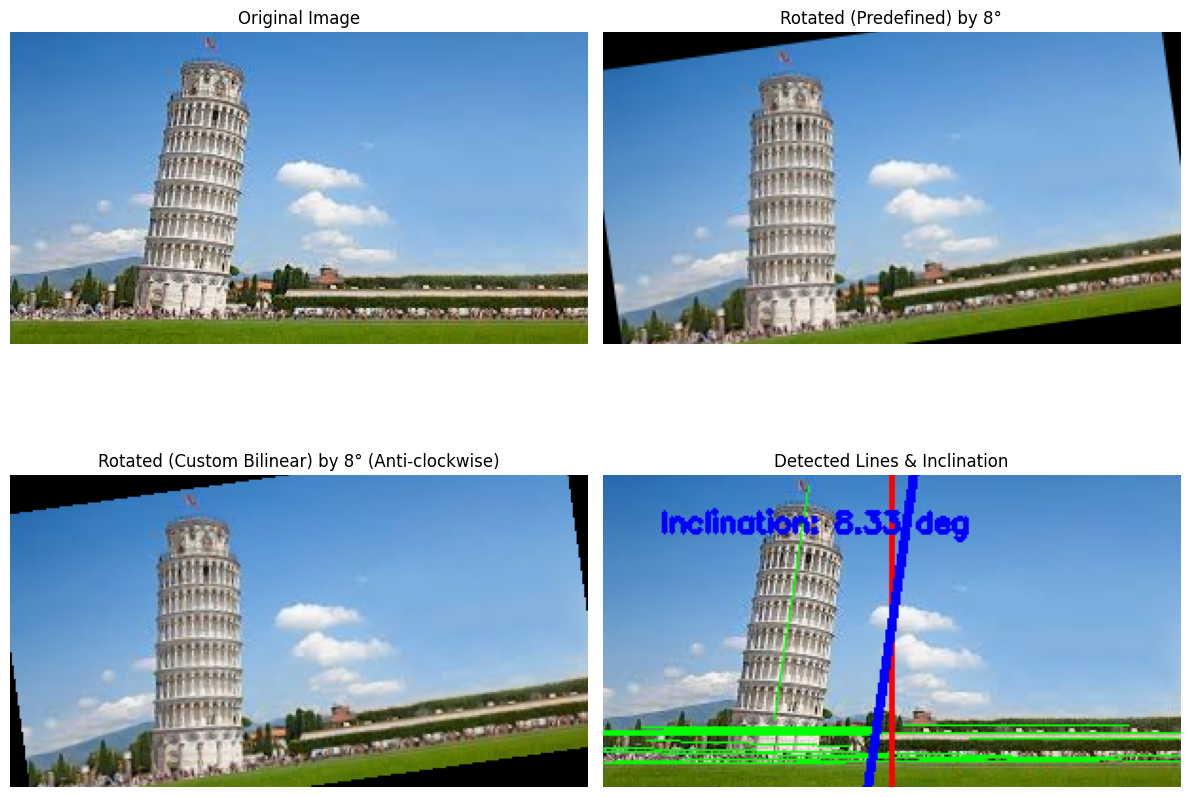

In [7]:
def main():
    image_path = 'pisa.jpeg'
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    angle_rotation = 8

    rotated_predefined = rotate_image_predefined(image, angle_rotation)
    rotated_custom = rotate_image_custom_bilinear(image, angle_rotation)

    line_image, inclination = detect_inclination(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rotated_predefined_rgb = cv2.cvtColor(rotated_predefined, cv2.COLOR_BGR2RGB)
    rotated_custom_rgb = cv2.cvtColor(rotated_custom, cv2.COLOR_BGR2RGB)
    line_image_rgb = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Original Image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(rotated_predefined_rgb)
    plt.axis('off')
    plt.title(f"Rotated (Predefined) by {angle_rotation}°")
    
    plt.subplot(2, 2, 3)
    plt.imshow(rotated_custom_rgb)
    plt.axis('off')
    plt.title(f"Rotated (Custom Bilinear) by {angle_rotation}° (Anti-clockwise)")
    
    plt.subplot(2, 2, 4)
    plt.imshow(line_image_rgb)
    plt.axis('off')
    plt.title("Detected Lines & Inclination")
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

________________